#Applying pattern recognition to the financial market

###-Testing

by Santiago Licea

In [ ]:
!pip install --quiet pmdarima
!pip install --quiet arch
!pip install --quiet prophet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_palette('pastel')
import yfinance as yf
import random
import datetime
from datetime import datetime, timedelta, date
import time
from google.colab import drive
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from arch.__future__ import reindexing #to shut down warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go

In this notebook, we test different time series forecasting models to determine if they are effective in predicting stock returns.

###Data extraction.

First we obtain the tickers from the companies in the S&P 500 listed in Wikipedia:

In [ ]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
df['Symbol'] = df.Symbol.str.replace('.', '-')
tickers = list(df.Symbol.values)

<ipython-input-4-3a839b743f33>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Symbol'] = df.Symbol.str.replace('.', '-')


Next we extract the dataframes with the stock prices for each company from 2018 to today and store them in a dictionary:

In [ ]:
dicCompanies = {}
startDate = '2018-01-01'
endDate = date.today().strftime('%Y-%m-%d')
for i in tickers:
  #Yahoo finance API call:
  df = yf.download(i, start = startDate, end = endDate, progress = False)
  df.reset_index(inplace=True)
  df['Date'] = pd.to_datetime(df['Date'])
  dicCompanies[i] = df

In [ ]:
def ROI(adjClose): #Return of investment function
  returns = []
  for i in range(len(adjClose)-1):
    returns.append((adjClose[i+1]-adjClose[i])/adjClose[i])
  return np.array(returns)

###ARIMA

For our time series predictions, we will ignore the weekend gaps in the data from the stock prices. We could apply Fill Forward or interpolation techniques but, interestingly enough, simply ignoring these gaps is the most widely way to proceed in most academic research.

We will compare two approaches for creating an ARIMA model: automatically calculating the best parameters with the auto_arima() funcion, and manually doing it ourselves. Let's start with the first approach:

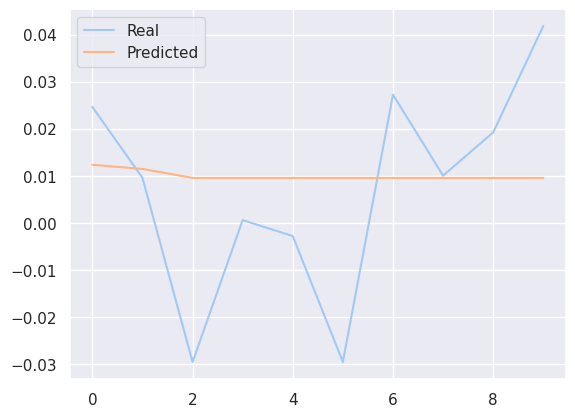

In [ ]:
#This can be modified:
ticker = 'NVDA'
startDate = "2023/01/01"
endDate = "2023/05/01"

adjClose = dicCompanies[ticker].query(f'Date >= "{startDate}" and Date <= "{endDate}"')['Adj Close'].values
returns = ROI(adjClose)
train = returns[:-10]
test = returns[-10:]

#We set d=0 since the returns of investments are already stationary
model = pm.auto_arima(train, d=0, error_action='ignore', suppress_warnings=True)
model.fit(train)
#We predict 10 days into de future
prediction1 = model.predict(n_periods=10)

#Let's visualize our prediciton
plt.plot(test, label='Real')
plt.plot(prediction1, label='Predicted')
plt.legend()
plt.show()

Now let's choose the parameters manually with the help of the partial autocorrelation and autocorrelation functions.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


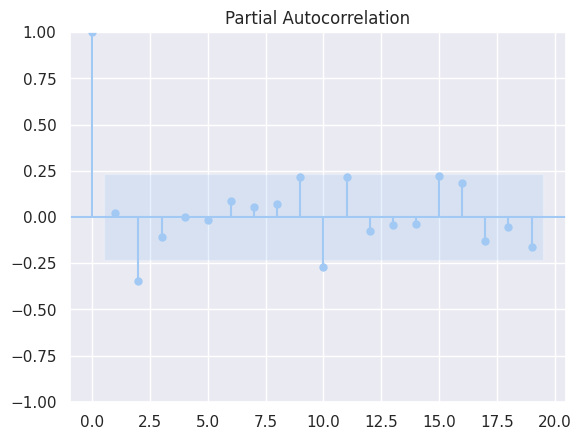

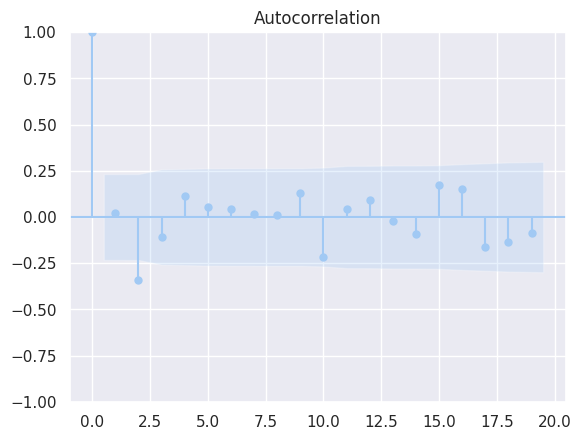

In [ ]:
plot_acf(train)
plot_pacf(train)
plt.show()

Let's choose p=q=2.

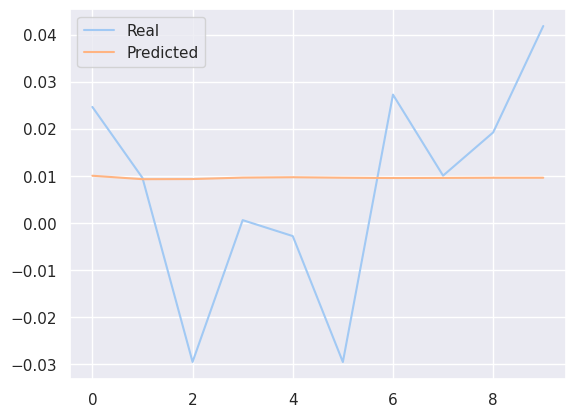

In [ ]:
arima = ARIMA(train, order=(2, 0, 2)).fit()
prediction2 = arima.forecast(steps=10)

plt.plot(test, label='Real')
plt.plot(prediction2, label='Predicted')
plt.legend()
plt.show()

Let's check the MSE for the two predictions:

In [ ]:
print(f'Automated prediction: {mse(test, prediction1)}')
print(f'Manual prediction: {mse(test, prediction2)}')

Automated prediction: 0.0004905599201122104
Manual prediction: 0.0004951084047942324


Repeating this with different tickers, we noticed no significant improvement doing it manually. However, we tested this for a limited number of companies and for a single time window, although the 3 month (aprox) time window seemed to work better across different tests for 2023.

We noticed that the auto_arima() function tends to generate simple models that don't predict far into the future. For that reason, we are going to use the ARIMA model exclusively to predict the return for the next day. To get a high level approximation of how well our auto generated ARIMA models will potentially predict the return for the next day, let's run a small simulation to obtain the accuracy of our model: (True Possitives + True Negatives)/Total.

In [ ]:
random.seed(1)

startDate = datetime.strptime("2021/01/01", "%Y/%m/%d")
endDate = datetime.strptime("2023/04/27", "%Y/%m/%d")
totalDays = (endDate - startDate).days
window = 105

predictions = []
testArr = []
for j in range(30):
  randomDays = random.randint(0, totalDays-window)
  randomStartDate = startDate + timedelta(days=randomDays)
  randomEndDate = randomStartDate + timedelta(days=window)

  for i in random.sample(tickers, 10):
    df = dicCompanies[i].query('Date >= @randomStartDate & Date <= @randomEndDate')
    adjClose = df['Adj Close'].values
    if len(adjClose) > window*0.6: #we will obtain less than 105 days because the market closes on the weekends, but here we check for companies with not enough data
      returns = ROI(adjClose)
      train = returns[:-1]
      testArr.append(returns[-1])
      model = pm.auto_arima(train, d=0, error_action='ignore', suppress_warnings=True)
      model.fit(train)
      predictions.append(model.predict(n_periods=1)[0])

We obtained many zero values for our predictions. This happens when we get an ARMA(0,0) model. In those cases, we won't include this model in the daily report. Let's meassure the accuracy only considering the non zero values:

In [ ]:
boolArr = []
for i in range(len(predictions)):
  if(predictions[i]!=0):
    boolArr.append((predictions[i]>0 and testArr[i]>0) or (predictions[i]<0 and testArr[i]<0))
print(f'ARIMA approx accuracy: {np.mean(boolArr)*100:.5f}%')

ARIMA approx accuracy: 45.56962%


Unfortunately, we get a similar accuracy to the one we would have obtained if we were to randomly guess between a possitive or a negative return for each prediction.

###EMA

We won't be trying with AR or MA models since the ARIMA already incorporates them (p and q can be zero). We also won't use SARIMA or SARIMAX since stock returns don't have a seasonal behaviour unlike other time series. Let us try to use the EMA model, which calculates a moving average, with the difference that it gives more weight to recent observations, allowing it to respond more quickly to changes in the time series data. Let's conduct a similar simulation and obtain the accuracy:

In [ ]:
random.seed(1)

startDate = datetime.strptime("2021/01/01", "%Y/%m/%d")
endDate = datetime.strptime("2023/04/27", "%Y/%m/%d")
totalDays = (endDate - startDate).days
window = 100

predictions = []
testArr = []
for j in range(30):
  randomDays = random.randint(0, totalDays-window)
  randomStartDate = startDate + timedelta(days=randomDays)
  randomEndDate = randomStartDate + timedelta(days=window)

  for i in random.sample(tickers, 10):
    df = dicCompanies[i].query('Date >= @randomStartDate & Date <= @randomEndDate')
    adjClose = df['Adj Close'].values
    if len(adjClose) > window*0.6:
      returns = ROI(adjClose)
      testArr.append(returns[-1])
      shortEma = pd.Series(returns[:-1]).ewm(span=10, adjust=False).mean() #we obtain similar results for span 8 through 15
      predictions.append(shortEma.values[-1])

In [ ]:
boolArr = []
for i in range(len(predictions)):
  if(predictions[i]!=0):
    boolArr.append((predictions[i]>0 and testArr[i]>0) or (predictions[i]<0 and testArr[i]<0))
print(f'EMA approx accuracy: {np.mean(boolArr)*100:.5f}%')

EMA approx accuracy: 53.33333%


We see an improvement compared to the ARIMA model and from random predictions. Our first choice for the time window (365 days) was actually the best choice after testing for other sizes.

###VARMA

In [ ]:
#This can be modified:
ticker = 'NVDA'
startDate = "2023/01/01"
endDate = "2023/05/01"

df = dicCompanies[ticker].query(f'Date >= "{startDate}" and Date <= "{endDate}"')[['Adj Close', 'Volume']]
train = df.iloc[:-10, :]
test = df.iloc[-10:, :]
test = ROI(test['Adj Close'].values)

returns = ROI(train['Adj Close'].values)
volume = train['Volume'].diff().values[1:] #we take the first difference to make the time series stationary

df = pd.DataFrame({'returns': returns, 'volumeDiff': volume})
scaler = MinMaxScaler() #this is important due to the scale of the volumes
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

model = VARMAX(df[['returns', 'volumeDiff']], order=(1, 1)).fit(disp=False)
#We predict, denormalize, and take only the returns
predictions = scaler.inverse_transform(model.forecast(steps=10-1))[:, 0]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


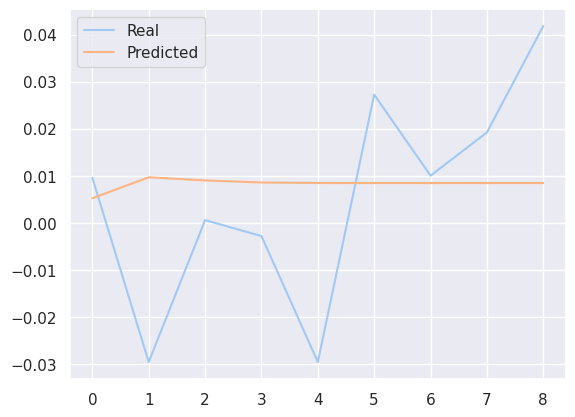

In [ ]:
plt.plot(test, label='Real')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [ ]:
print(f'Automated prediction: {mse(test, predictions)}')

Automated prediction: 0.0005333453105947385


Let's run a simulation like the past ones we have created, although we will conduct a grid search to find the best p and q parameters using the AIC since there's no available function to make this automatically like with auto_arima(). (it took 9 minutos for a grid search of p and q over range(3) and 20 min for range(4) with the same accuracy result)

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

#To ignore convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

random.seed(1)

startDate = datetime.strptime("2021/01/01", "%Y/%m/%d")
endDate = datetime.strptime("2023/04/27", "%Y/%m/%d")
totalDays = (endDate - startDate).days
window = 105

testArr = []
predictions = []
bestParamsArr = []
for j in range(20):
  randomDays = random.randint(0, totalDays-window)
  randomStartDate = startDate + timedelta(days=randomDays)
  randomEndDate = randomStartDate + timedelta(days=window)
  for i in random.sample(tickers, 5):
    df = dicCompanies[i].query('Date >= @randomStartDate & Date <= @randomEndDate')
    if len(df['Adj Close'].values) > window*0.6:
      returns = ROI(df['Adj Close'].values)
      volume = df['Volume'].diff().values[1:]
      testArr.append(returns[-1])

      df = pd.DataFrame({'returns': returns[:-1], 'volumeDiff': volume[:-1]})
      scaler = MinMaxScaler()
      df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

      bestAIC = np.inf
      bestParams = None
      for p in range(4):
        for q in range(4):
          try:
            model = VARMAX(df[['returns', 'volumeDiff']], order=(p, q)).fit(disp=False)
            aic = model.aic
            if aic < bestAIC:
              bestAIC = aic
              bestParams = (p, q)
          except:
            continue
      bestParamsArr.append(bestParams)
      model = VARMAX(df[['returns', 'volumeDiff']], order=bestParams).fit(disp=False)
      predictions.append(scaler.inverse_transform(model.forecast(steps=1))[0, 0])

In [ ]:
print(bestParamsArr)

[(0, 1), (0, 2), (0, 2), (0, 2), (0, 3), (0, 2), (0, 1), (0, 2), (0, 1), (0, 1), (0, 3), (0, 2), (0, 2), (0, 1), (1, 1), (0, 1), (0, 2), (0, 1), (0, 1), (0, 1), (0, 1), (0, 2), (0, 1), (0, 2), (0, 2), (0, 1), (0, 2), (0, 1), (0, 1), (0, 2), (0, 1), (0, 2), (2, 3), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 3), (0, 2), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 2), (0, 1), (3, 0), (0, 3), (0, 1), (0, 2), (0, 1), (0, 1), (0, 2), (0, 1), (0, 1), (0, 3), (0, 1), (0, 2), (0, 1), (0, 1), (0, 3), (0, 1), (0, 2), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 3), (0, 1), (2, 0), (0, 1), (0, 1), (0, 1), (0, 2), (0, 1), (0, 1), (2, 0), (0, 1), (0, 1), (0, 2), (0, 2), (0, 2), (0, 2), (0, 1), (0, 2), (0, 1), (0, 1), (0, 1), (0, 3), (0, 1), (0, 3), (0, 1), (0, 2)]


In [ ]:
boolArr = []
for i in range(len(predictions)):
  if(predictions[i]!=0):
    boolArr.append((predictions[i]>0 and testArr[i]>0) or (predictions[i]<0 and testArr[i]<0))
print(f'Approx accuracy: {np.mean(boolArr)*100:.5f}%')

ARIMA approx accuracy: 49.00000%


49% accuracy for a grid search of range(3) and range(4)

We had several complications when trying to find times series data for other variables such as interest rates, price to earnings ratio, etc. for all companies. The solution is to use the Alpha Vantage API, but it has a cost.

###GARCH

Let's apply a GARCH model to predict the volatility for the next 365 days. This can be useful in determining the risk of an investment.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


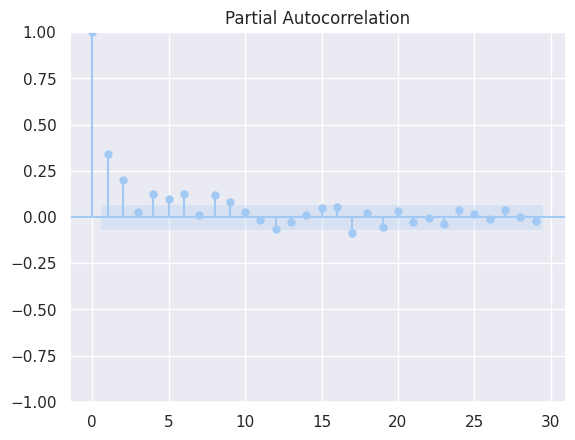

In [ ]:
#This can be modified:
ticker = 'AAPL'
startDate = "2019/01/01" #we obtained a similar result for 2018 and 2020
endDate = "2023/05/01"

#It is recommended to multiply y*100:
returns = ROI(dicCompanies[ticker].query(f'Date >= "{startDate}" and Date <= "{endDate}"')['Adj Close'].values)*100
testSize = 365
train, test = returns[:-testSize], returns[-testSize:]

plot_pacf(train**2)
plt.show()

We create the model:

In [ ]:
model = arch_model(train, p=2, q=2).fit(disp='off') #We adjust q based on the p-values obtained
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1462.55
Distribution:                  Normal   AIC:                           2937.10
Method:            Maximum Likelihood   BIC:                           2964.61
                                        No. Observations:                  724
Date:                Wed, May 31 2023   Df Residuals:                      723
Time:                        00:10:36   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3074  6.189e-02      4.967  6.791e-07 [  0.186,  0.429]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2875      0.106      2.702  6.901e-03  [7.892e-02,  0.496]
alpha[1]       0.0738  4.503e-02      1.640      0.101 [-1.442e-02,  0.162]
alpha[2]       0.2142  6.917e-02      3.096  1.962e-03  [7.858e-02,  0.350]
beta[1]        0.0188      0.102      0.184      0.854    [ -0.182,  0.219]
beta[2]        0.6332      0.110      5.769  7.983e-09    [  0.418,  0.848]
===========================================================================

Covariance estimator: robust
"""

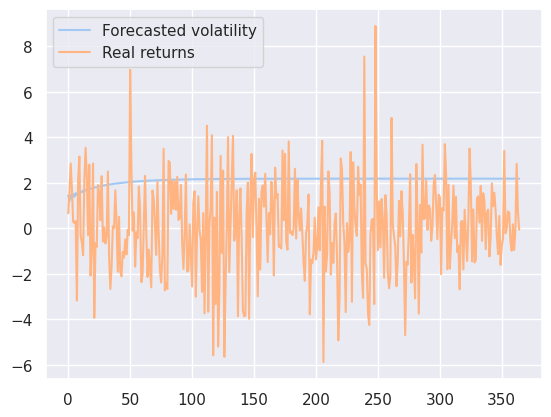

In [ ]:
#From the forecast object we created we take the last 10 values of the forecasted variance and take the sqrt
forecast = model.forecast(horizon=testSize).variance.values[-1, :]**0.5

plt.plot(forecast, label='Forecasted volatility')
plt.plot(test, label='Real returns')
plt.legend()
plt.show()

We don't obtain a very good prediction of the volatility. Let's train a same model for different time windows to predict a single day on each iteration. (we took this strategy from https://www.youtube.com/watch?v=NKHQiN-08S8&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=27)

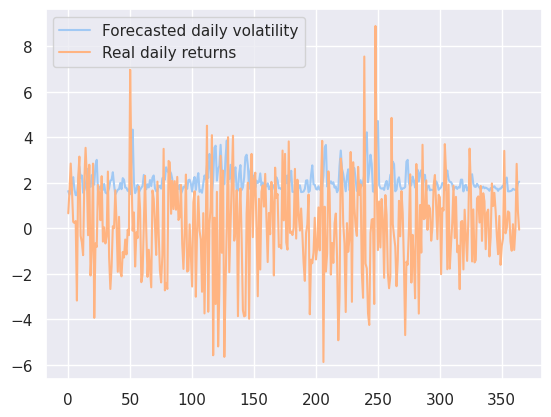

In [ ]:
predictions = []
for i in range(testSize):
  model = arch_model(returns[:-testSize+i], p=2, q=0).fit(disp='off')
  predictions.append(model.forecast(horizon=1).variance.values[-1, :][0]**0.5)

plt.plot(predictions, label='Forecasted daily volatility')
plt.plot(test, label='Real daily returns')
plt.legend()
plt.show()

We see a correlation between the stock return's fluctuations and the predicted volatility, although the latter has a small lag. So we can manually fit a GARCH model for each company with sufficient historical data and use this same parameters to predict the volatility for the next day. Let's see if we can automate the generation of the parameters for each company.

In [ ]:
random.seed(1)

startDate = "2019/01/01"
endDate = "2023/05/01"

bestParamsArr = []
for ticker in tickers:
  returns = ROI(dicCompanies[ticker].query(f'Date >= "{startDate}" & Date <= "{endDate}"')['Adj Close'].values)*100

  bestAIC = np.inf
  bestParams = None
  for p in range(4):
    for q in range(4):
      try:
        model = arch_model(returns, p=p, q=q).fit(disp='off')
        aic = model.aic
        if aic < bestAIC:
          bestAIC = aic
          bestParams = (p, q)
      except:
        continue
  bestParamsArr.append(bestParams)

In [ ]:
print(bestParamsArr)

[(1, 3), (1, 2), (1, 2), (1, 1), (1, 1), (1, 3), (1, 1), (2, 1), (1, 1), (2, 3), (1, 2), (2, 3), (1, 1), (1, 1), (3, 3), (2, 2), (3, 0), (1, 1), (3, 1), (2, 3), (1, 1), (2, 3), (1, 2), (1, 2), (1, 3), (1, 2), (1, 1), (2, 2), (1, 1), (1, 1), (1, 1), (2, 3), (1, 1), (1, 1), (1, 1), (1, 3), (1, 1), (1, 2), (2, 2), (1, 1), (2, 2), (2, 2), (3, 2), (1, 2), (1, 1), (1, 1), (2, 3), (2, 2), (3, 1), (2, 1), (3, 1), (3, 0), (3, 3), (1, 1), (3, 1), (1, 1), (1, 1), (2, 3), (1, 1), (2, 3), (2, 2), (1, 3), (1, 2), (3, 1), (1, 2), (1, 1), (3, 1), (1, 2), (1, 2), (3, 0), (1, 1), (1, 1), (1, 1), (2, 2), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (3, 3), (1, 1), (3, 0), (1, 1), (1, 3), (2, 2), (2, 1), (2, 3), (1, 1), (1, 3), (2, 3), (1, 1), (1, 2), (2, 1), (1, 2), (1, 1), (2, 1), (1, 1), (1, 1), (1, 2), (1, 3), (1, 1), (1, 1), (2, 3), (1, 2), (3, 1), (3, 2), (3, 3), (1, 2), (2, 3), (1, 1), (2, 3), (1, 3), (2, 3), (2, 3), (1, 2), (1, 1), (2, 3), (2, 1), (1, 3), (1, 1), (1, 2), (2, 3), (2, 3),

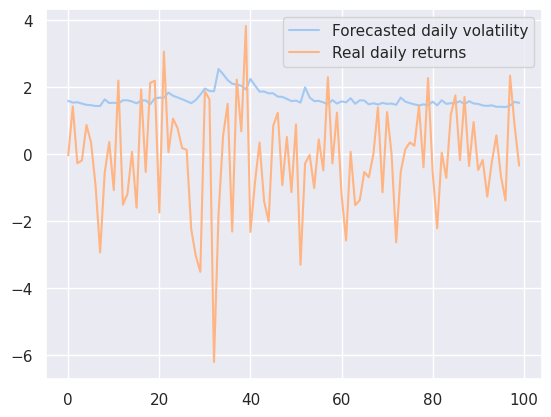

In [ ]:
#Let's fit a model to the i-th ticker with the i-th tuple of parameters in bestParamsArr
startDate = "2019/01/01"
endDate = "2023/05/01"
i = 0
testSize = 100
returns = ROI(dicCompanies[tickers[i]].query(f'Date >= "{startDate}" and Date <= "{endDate}"')['Adj Close'].values)*100
test = returns[-testSize:]

predictions = []
for i in range(testSize):
  model = arch_model(returns[:-testSize+i], p=bestParamsArr[i][0], q=bestParamsArr[i][1]).fit(disp='off')
  predictions.append(model.forecast(horizon=1).variance.values[-1, :][0]**0.5)

plt.plot(predictions, label='Forecasted daily volatility')
plt.plot(test, label='Real daily returns')
plt.legend()
plt.show()

We get a similar result than with the manual selection of parameters. Now let's see if obtaining different paraments on each day improves the predictions.

In [ ]:
i = 0 #for the first company in 'tickers' we are going to obtain the best parameters for each of 100 days
startDate = "2019/01/01"
endDate = "2023/05/01"
testSize = 100
returns = ROI(dicCompanies[tickers[i]].query(f'Date >= "{startDate}" and Date <= "{endDate}"')['Adj Close'].values)*100
test = returns[-testSize:]

bestParamsArr = []
for i in range(testSize):
  bestAIC = np.inf
  bestParams = None
  for p in range(4):
    for q in range(4):
      try:
        model = arch_model(returns[:-testSize+i], p=p, q=q).fit(disp='off')
        aic = model.aic
        if aic < bestAIC:
          bestAIC = aic
          bestParams = (p, q)
      except:
        continue
  bestParamsArr.append(bestParams)

Without having to visualize, we notice that we obtained the same parameters for each day, meaning that for any company (we verified for others), we can use the same parameters to daily train our GARCH volatility prediction and use this same parameters for at least 100 days.

In [ ]:
print(bestParamsArr)

[(1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3), (1, 3)]


###Prophet

In [ ]:
#This can be modified:
ticker = 'NVDA'
startDate = "2018/01/01"
endDate = "2023/05/01"
testSize = 100

#Train test split
df = dicCompanies[ticker].query(f'Date >= "{startDate}" and Date <= "{endDate}"')[['Date', 'Adj Close']]
df = df.rename(columns={'Date': 'ds', 'Adj Close': 'y'})
returns = ROI(df['y'].values)
df['ds'] = pd.to_datetime(df['ds'])
df = df.iloc[1:, :]
df['y'] = returns
train, test = df.iloc[:-testSize, :], df.iloc[-testSize:, :]

model = Prophet(changepoint_prior_scale=5, seasonality_prior_scale=0.1).fit(train)
futureDates = model.make_future_dataframe(periods=int((testSize*31)/20)) #the test does not contain weekend values so we have to predict more values to compare predictions vs test
predictions = model.predict(futureDates)

#Since the model predicts consecutive dates, we get rid of the dates not present in the test df
testDates = test['ds'].values
predictions = [predictions.loc[i, 'yhat'] for i, date in enumerate(predictions['ds'].values) if date in testDates]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2iqw0qrq/tez48uvr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2iqw0qrq/q7rkqpa7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35655', 'data', 'file=/tmp/tmp2iqw0qrq/tez48uvr.json', 'init=/tmp/tmp2iqw0qrq/q7rkqpa7.json', 'output', 'file=/tmp/tmp2iqw0qrq/prophet_modelxnqbhekk/prophet_model-20230530204142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:41:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:41:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


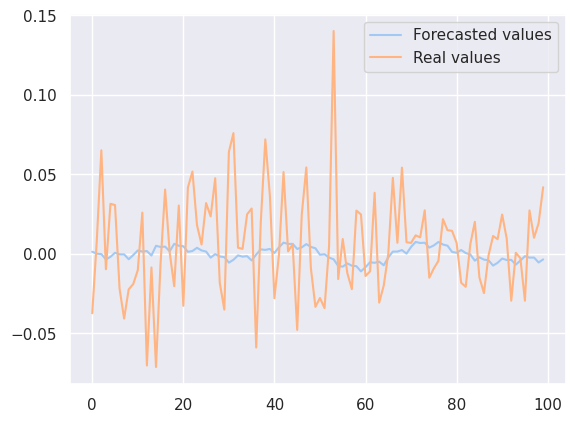

In [ ]:
plt.plot(predictions, label='Forecasted values')
plt.plot(test.y.values, label='Real values')
plt.legend()
plt.show()

In [ ]:
mse(test.y.values, predictions)

0.0011284404923891957

Even though the error is not too bad, we won't include this model in our product. After adjusting for several paramenters, it looks like it's only good for predicting long term patterns. However, it focuses on capturing seasonality.

###LSTM

In [ ]:
random.seed(0)
startDate = "2018/01/01"
endDate = "2023/05/01"

lossArr = []
accArr = []
for ticker in random.sample(tickers, 30):
  returns = ROI(dicCompanies[ticker].query(f'Date >= "{startDate}" and Date <= "{endDate}"')['Adj Close'].values)
  scaler = MinMaxScaler()
  returns = scaler.fit_transform(returns.reshape(-1, 1))

  #LSTM input
  X = []
  y = []
  lookback = 10 #we chose this lookback window due to the volatility of stock returns
  for i in range(lookback, len(returns)):
      X.append(returns[i-lookback:i, 0])
      y.append(returns[i, 0])
  X, y = np.array(X), np.array(y)
  X = np.reshape(X, (X.shape[0], X.shape[1], 1)) #to 3D array

  #Train test split
  XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

  #LSTM model
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(XTrain.shape[1], 1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  #Compiling
  model.compile(optimizer='adam', loss='mean_squared_error')

  #Train
  model.fit(XTrain, yTrain, batch_size=50, epochs=50, verbose=0)

  #Evaluate
  lossArr.append(model.evaluate(XTest, yTest)) #mse of yHat and yTest

  #Predict
  predictions = model.predict(XTest)
  predictions = scaler.inverse_transform(predictions)
  boolArr = []
  for i in range(len(predictions)):
    boolArr.append((predictions[i][0]>0 and yTest[i]>0) or (predictions[i][0]<0 and yTest[i]<0))
  accArr.append(np.mean(boolArr)*100)

In [ ]:
np.mean(accArr)

61.673921030400464

Since the test split picks xTest and yTest pairs at random, we efectively evaluate our model at random time windows. After testing for 30 different companies, with differend seeds, it looks like on average, the model has a little bit above 50% accuracy in predicting possitive or negative returns.

###K-means

Let's see if we can cluster the companies by 6 different financial dimensions with K-means.

In [ ]:
dimensions = ['trailingPE', 'returnOnEquity', 'dividendYield', 'beta', 'marketCap', 'debtToEquity']
dicInfo = {}
for ticker in tickers:
  dicInfo[ticker] = []
  dicTicker = yf.Ticker(ticker).info
  for dim in dimensions:
    try:
      dicInfo[ticker].append(dicTicker[dim])
    except:
      continue

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

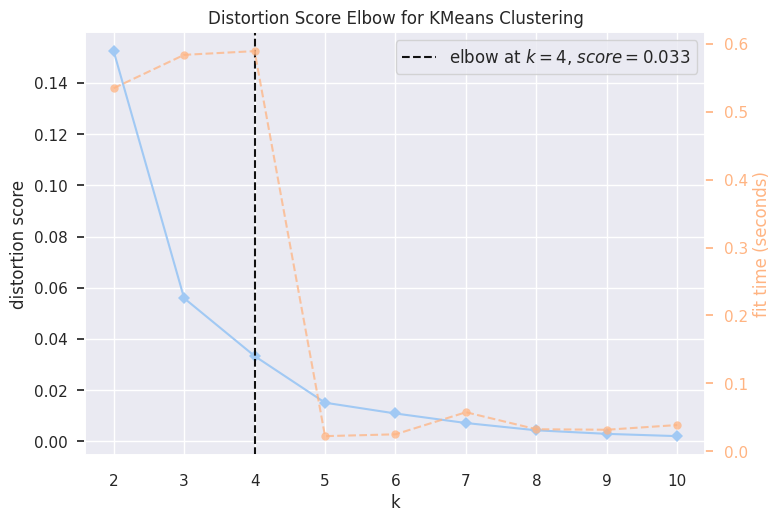

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
dicInfo2 = {}
for i in dicInfo.keys():
  if len(dicInfo[i])==6:
    dicInfo2[i] = dicInfo[i]
X = []
for i in dicInfo2.keys():
  X.append(dicInfo2[i])
X = np.array(X)

model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2, 11))
visualizer.fit(X)
visualizer.show()

The Elbow Chart suggests k=4. Consider that we were only able to retrieve all the dimensions for 330 companies:

In [ ]:
len(X)

330

We apply kmeans and project the data to 3D to visualize the clusters.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
labels = pd.Categorical(kmeans.labels_)

datos3D = PCA(n_components=3).fit_transform(X)

fig = px.scatter_3d(
    x=datos3D[:,0], y=datos3D[:,1], z=datos3D[:,2], color=labels,
     color_discrete_sequence=['#003f5c', '#bc5090', '#ffa600', '#90EE90'])
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



We see that the four clusters are not so equally divided through space. The graph shows the great difference in scale for some of the dimensions in each cluster. Let us now analyze the distribution of the financial variables across each cluster, as well as the types of companies belonging to each.

In [ ]:
zero = [i==0 for i in labels]
one = [i==1 for i in labels]
two = [i==2 for i in labels]
three = [i==3 for i in labels]

groups = [zero, one, two, three]
colors = ['#003f5c', '#bc5090', '#ffa600', '#90EE90']
names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
dimensions = ['trailingPE', 'returnOnEquity', 'dividendYield', 'beta', 'marketCap', 'debtToEquity']

datos = pd.DataFrame(data=X, columns=dimensions)

for indicador in dimensions:
  fig = go.Figure()
  for i, c, t in zip(groups, colors, names):
    df_cluster = datos[i]
    boxplot = go.Box(y=df_cluster[indicador], name=t, marker_color=c)
    fig.add_trace(boxplot)
  fig.update_layout(title=indicador, title_x=0.5, title_y=0.95, yaxis_title=indicador)
  fig.show()

Let's see how many and to which cluster companies belong to:

In [ ]:
zero = [i==0 for i in labels]
one = [i==1 for i in labels]
two = [i==2 for i in labels]
three = [i==3 for i in labels]

print(np.sum(zero))
print(np.sum(one))
print(np.sum(two))
print(np.sum(three))

275
2
10
43


In [ ]:
companies = list(dicInfo2.keys())
for k in [zero, one, two, three]:
  print([companies[i] for i, j in enumerate(k) if j])

['MMM', 'AOS', 'ADM', 'ADP', 'AAP', 'AFL', 'A', 'APD', 'ALB', 'ARE', 'ALLE', 'LNT', 'AMCR', 'AEE', 'AEP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'APH', 'ADI', 'AON', 'APA', 'AJG', 'AIZ', 'ATO', 'AVB', 'AVY', 'BALL', 'BDX', 'WRB', 'BBY', 'TECH', 'BWA', 'BXP', 'BR', 'BRO', 'BF-B', 'BG', 'CHRW', 'CPT', 'CPB', 'CARR', 'CBOE', 'CDW', 'CE', 'CNP', 'CF', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CLX', 'CME', 'CMS', 'CTSH', 'CL', 'CAG', 'ED', 'COO', 'GLW', 'CTVA', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DRI', 'DVN', 'FANG', 'DLR', 'DFS', 'DG', 'D', 'DOV', 'DOW', 'DTE', 'DUK', 'DD', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EA', 'EMR', 'ETR', 'EOG', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'RE', 'ES', 'EXC', 'EXPD', 'EXR', 'FDS', 'FAST', 'FRT', 'FDX', 'FE', 'FMC', 'F', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'GEN', 'GD', 'GIS', 'GM', 'GPC', 'GL', 'HAL', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSY', 'HES', 'HPE', 'HRL', 'HST', 'HWM', 'HUM', 'HII', 'IEX', 'ITW', 'IR', 'ICE', 'IP', 'IPG', 'IVZ', 'INVH', 'I